# Training a classifier

## Что насчет данных

Обычно, когда вам приходится иметь дело с изображениями, текстом, аудио- или видеоданными, вы можете использовать стандартные пакеты python, которые загружают данные в массив numpy. Затем вы можете преобразовать этот массив в `torch.*Tensor`.

* Для изображений полезны такие пакеты, как Pillow, OpenCV
* Для аудио - такие пакеты, как scipy и librosa
* Для работы с текстом - либо сырой Python, либо загрузка на основе Cython, либо NLTK или SpaCy

Специально для зрения мы создали пакет torchvision, в котором есть загрузчики данных для распространенных наборов данных, таких как ImageNet, CIFAR10, MNIST и т. д., и трансформеры для изображений, а именно torchvision.datasets и torch.utils.data.DataLoader.

В этом руководстве мы будем использовать набор данных CIFAR10. В нем есть классы: "самолет", "автомобиль", "птица", "кошка", "олень", "собака", "лягушка", "лошадь", "корабль", "грузовик". Изображения в CIFAR-10 имеют размер 3x32x32, то есть 3-канальные цветные изображения размером 32x32 пикселя.

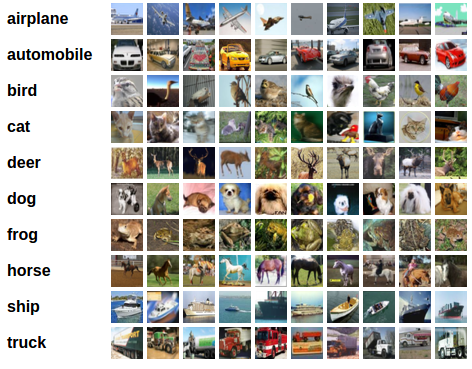


## Обучение классификатора изображений

Мы выполним следующие шаги:

1. Загрузим и нормализуем наборы обучающих и тестовых данных CIFAR10 с помощью torchvision
2. Определим конволюционную нейронную сеть (CNN)
3. Определим функцию потерь
4. Обучим сеть на обучающих данных
5. Протестируем сеть на тестовых данных

### 1. Загрузка и нормализация CIFAR10

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

Выходными значением датасетов torchvision будут изображения PILImage с диапазоном \[0, 1\]. Мы преобразуем их в тензоры нормализованного диапазона \[-1\, 1\]

Примечание: Если вы работаете под Windows и получаете ошибку BrokenPipeError, попробуйте установить значение `num_worker` в функции `torch.utils.data.DataLoader()` равным 0.

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                      download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


Давайте посмотрим некоторые изображения из обучающего датасета

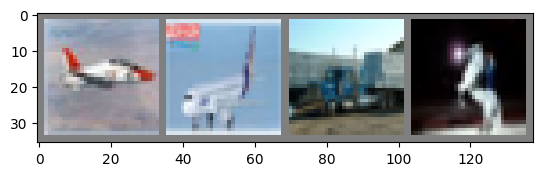

plane plane truck horse


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# функции для отображения картинки


def imshow(img):
    img = img / 2 + 0.5  # ненормировать
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# получить несколько случайных обучающих изображений
dataiter = iter(trainloader)
images, labels = next(dataiter)

# отображение картинки
imshow(torchvision.utils.make_grid(images))
# вывод лейблов
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### 2. Определяем CNN

Cкопируем нейронную сеть из раздела "Нейронные сети" и изменим ее так, чтобы она принимала 3-канальные изображения (а не 1-канальные, как было определено ранее).

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 20, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(20, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # сглаживание всех измерений, кроме batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### 3. Определяем функцию потерь и оптимизатор

Воспользуемся классификацией Cross-Entropy loss и SGD с импульсом

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Обучаем сеть

Нам нужно просто перебирать итератор данных, подавать входные данные в сеть и оптимизировать.

In [6]:
for epoch in range(2):  # проходим через датасет несколько раз
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # получает входные данные; данные это список из [входные данные, лейблы]
        inputs, labels = data

        # обнуляем градиенты параметров
        optimizer.zero_grad()

        # forward + backward + оптимизация
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику
        running_loss += loss.item()
        if i % 2000 == 1999:  # выводим каждую 2000 мини-батчу
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
print('Тренировка окончена')

[1,  2000] loss: 2.210
[1,  4000] loss: 1.821
[1,  6000] loss: 1.627
[1,  8000] loss: 1.515
[1, 10000] loss: 1.456
[1, 12000] loss: 1.393
[2,  2000] loss: 1.327
[2,  4000] loss: 1.293
[2,  6000] loss: 1.263
[2,  8000] loss: 1.224
[2, 10000] loss: 1.183
[2, 12000] loss: 1.150
Тренировка окончена


Давайте сохраним натренированную модель

In [7]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

Подробная [информация](https://pytorch.org/docs/stable/notes/serialization.html) про сохранение моделей PyTorch.

### 5. Тестирование модели на тестовых данных

Мы обучили сеть за 2 прохода по обучающему набору данных. Но нам нужно проверить, научилась ли сеть вообще чему-либо.

Мы проверим это, предсказав метку класса, которую выдает нейронная сеть, и сверив ее с истиной. Если предсказание верно, мы добавляем образец в список правильных предсказаний.

Для начала выведем на экран изображение из тестового набора, чтобы ознакомиться с ним

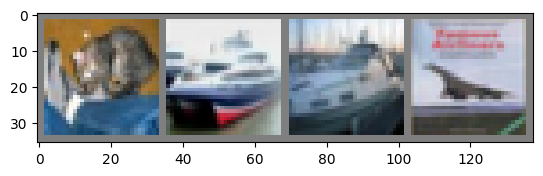

GroundTruth:  cat   ship  ship  plane


In [8]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# выводим изображения
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Далее давайте загрузим обратно нашу сохраненную модель (примечание: сохранение и повторная загрузка модели здесь не обязательны, мы сделали это только для того, чтобы проиллюстрировать, как это делается)

In [9]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Хорошо, теперь давайте посмотрим, что нейронная сеть считает этими примерами

In [10]:
outputs = net(images)

На выходе получаются энергии для 10 классов. Чем выше энергия для класса, тем больше сеть считает, что изображение относится к данному классу. Итак, получим индекс с наибольшей энергией

In [11]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  plane


Теперь давайте посмотрим, как сеть будет взаимодействовать с целым датасетом

In [12]:
correct = total = 0
# поскольку мы не обучаемся, нам не нужно вычислять градиенты для наших выходов
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # вычисляем выходное значение, пропустим изображения через сеть
        outputs = net(images)
        # класс с наибольшей энергией это то, что мы выбираем в качестве предсказания
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Точность сети на 10000 изображениях: {100 * correct // total} %')


Точность сети на 10000 изображениях: 60 %


Это намного лучше, чем случайность, которая составляет 10 % точности (случайный выбор класса из 10 классов). Похоже, что сеть чему-то научилась.

Посмотрим, какие классы показали хорошие результаты, а какие не очень.

In [13]:
# готовимся к вычислению предсказаний для каждого класса
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# опять же, градиент не нужен
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # собираем правильные предсказания для каждого класса
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# выводим точность для каждого класса
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Точность для класса: {classname:5s} is {accuracy:.1f} %')

Точность для класса: plane is 60.9 %
Точность для класса: car   is 62.2 %
Точность для класса: bird  is 54.6 %
Точность для класса: cat   is 47.9 %
Точность для класса: deer  is 48.6 %
Точность для класса: dog   is 46.9 %
Точность для класса: frog  is 68.5 %
Точность для класса: horse is 66.3 %
Точность для класса: ship  is 76.8 %
Точность для класса: truck is 72.6 %


Теперь запустим обучение на GPU

### Обучение на GPU

Так же, как вы перемещаете тензор на GPU, вы перемещаете нейронную сеть на GPU

Для начала определим наше устройство как первое видимое устройство CUDA, если CUDA доступно

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Предполагая, что на устройстве есть CUDA, выведется устройство CUDA

print(device)

cuda:0


Затем эти методы рекурсивно пройдут по всем модулям и преобразуют их параметры и буферы в тензоры CUDA:

In [15]:
net.to(device)

Net(
  (conv1): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Помните, что на каждом шаге вам придется отправлять входные данные и целевые переменные на графический процессор

In [16]:
inputs, labels = data[0].to(device), data[1].to(device)

Почему нет МАССОВОГО ускорения по сравнению с процессором? Потому что наша сеть очень маленькая.

Упражнение: Попробуйте увеличить ширину сети (аргумент 2 первого nn.Conv2d и аргумент 1 второго nn.Conv2d - они должны быть одинаковыми), посмотрите, какое ускорение вы получите.